In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Dense, Activation,Conv2D,Dropout,MaxPooling2D,Flatten,Convolution2D
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.applications import *

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


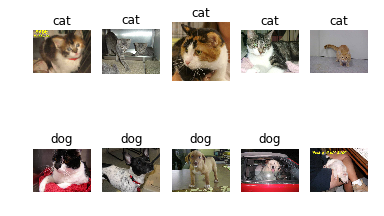

In [2]:
def data_display():
    '''
    随机展示5张猫的图片，5张狗的图片
    '''
    for i in range(0,10):
            index = random.randint(0, 12500)
            if (i<=5):
                plt.title('cat')
                img = Image.open('train/cat.%d.jpg' %index)
            else:
                plt.title('dog')
                img = Image.open('train/dog.%d.jpg' %index)
            plt.subplot(2, 5, i+1)
            plt.imshow(img)
            plt.axis('off')
    plt.show()
    
data_display()

In [3]:
def train_vaild_dataset(n,image_size):
    X = np.zeros((n,image_size,image_size,3),dtype=np.uint8)
    y = np.zeros((n,1),dtype=np.uint8)
    for i in tqdm(range(n/2)):
        X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' %i),(image_size,image_size))
        X[i+n/2] = cv2.resize(cv2.imread('train/dog.%d.jpg' %i),(image_size,image_size))
    y[n/2:] = 1
    
    return X,y

In [4]:
def test_resize(n,image_size):
    X_test = np.zeros((n,image_size,image_size,3),dtype=np.uint8)
    for i in tqdm(range(1,n+1)):
        X_test[i-1] = cv2.resize(cv2.imread('test/%d.jpg' %i),(image_size,image_size))
    return X_test

In [5]:
X,y = train_vaild_dataset(25000,224)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)
X_test = test_resize(12500,224)

100%|██████████| 12500/12500 [00:24<00:00, 503.21it/s]


In [22]:
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(4, (5, 5), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer=sgd,metrics=['accuracy'])
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=5,validation_data=(X_valid,y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 10s 489us/step - loss: 0.9652 - acc: 0.5770 - val_loss: 0.6233 - val_acc: 0.6626
Epoch 2/10
20000/20000 [==============================] - 9s 471us/step - loss: 0.6240 - acc: 0.6593 - val_loss: 0.5881 - val_acc: 0.6918
Epoch 3/10
20000/20000 [==============================] - 10s 482us/step - loss: 0.5736 - acc: 0.7085 - val_loss: 0.5640 - val_acc: 0.7186
Epoch 4/10
20000/20000 [==============================] - 9s 472us/step - loss: 0.5404 - acc: 0.7364 - val_loss: 0.5088 - val_acc: 0.7716
Epoch 5/10
20000/20000 [==============================] - 9s 472us/step - loss: 0.5104 - acc: 0.7543 - val_loss: 0.5123 - val_acc: 0.7490
Epoch 6/10
20000/20000 [==============================] - 9s 471us/step - loss: 0.4925 - acc: 0.7701 - val_loss: 0.4940 - val_acc: 0.7686
Epoch 7/10
20000/20000 [==============================] - 9s 470us/step - loss: 0.4705 - acc: 0.7810 - val_loss: 0.4419 -

In [23]:
pre = model.predict(X_test, batch_size=32, verbose=0)

In [24]:

##将预测写入csv
with open('submission.csv','w') as f:
    f.write('id,label\n')
with open('submission.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [00:19<00:00, 625.94it/s]


## 用VGG模型进行迁移学习

In [6]:
X,y = train_vaild_dataset(25000,224)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)
X_test = test_resize(12500,224)

100%|██████████| 12500/12500 [00:24<00:00, 505.53it/s]


In [8]:
from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Dense
from keras.applications.vgg16 import VGG16
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

inputs = Input(shape=(224,224,3))

base_model = VGG16(weights='imagenet',input_tensor=inputs, include_top=False)

x = base_model.output
x = Flatten()(x)
# x = Dense(1028,activation='relu')(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(1,activation='sigmoid')(x)

model = Model(inputs, output)
opt = SGD(lr=0.0001, momentum=0.9)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5,batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1499 - acc: 0.9576 - val_loss: 0.0488 - val_acc: 0.9828
Epoch 2/5
20000/20000 [==============================] - 118s 6ms/step - loss: 0.0281 - acc: 0.9895 - val_loss: 0.0431 - val_acc: 0.9840
Epoch 3/5
20000/20000 [==============================] - 118s 6ms/step - loss: 0.0129 - acc: 0.9955 - val_loss: 0.0461 - val_acc: 0.9860
Epoch 4/5
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0547 - val_acc: 0.9848
Epoch 5/5
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0045 - acc: 0.9992 - val_loss: 0.0504 - val_acc: 0.9874


In [9]:
pre = model.predict(X_test, batch_size=32, verbose=0)

In [10]:

##将预测写入csv
with open('submission.csv','w') as f:
    f.write('id,label\n')
with open('submission.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [01:12<00:00, 173.60it/s]


## 用Xception模型进行迁移学习

In [16]:
X,y = train_vaild_dataset(25000,299)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)
X_test = test_resize(12500,299)

100%|██████████| 12500/12500 [00:27<00:00, 449.83it/s]


In [7]:
from keras.applications.xception import Xception
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

input = Input(shape=(299, 299, 3))
base_model = Xception(weights='imagenet', input_tensor=input,include_top=False)

x = Flatten()(base_model.output)
#x = Dense(2048, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model_Xception = Model(input=input, output=output)


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [8]:
opt = SGD(lr=0.0001, momentum=0.9)
model_Xception.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model_Xception.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=5,batch_size=32)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 252s 13ms/step - loss: 0.0803 - acc: 0.9693 - val_loss: 0.0385 - val_acc: 0.9854
Epoch 2/5
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0360 - acc: 0.9870 - val_loss: 0.0333 - val_acc: 0.9872
Epoch 3/5
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0282 - acc: 0.9902 - val_loss: 0.0314 - val_acc: 0.9896
Epoch 4/5
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0200 - acc: 0.9932 - val_loss: 0.0310 - val_acc: 0.9894
Epoch 5/5
20000/20000 [==============================] - 248s 12ms/step - loss: 0.0171 - acc: 0.9941 - val_loss: 0.0319 - val_acc: 0.9882


In [10]:
pre_Xception = model_Xception.predict(X_test, batch_size=32, verbose=0)

In [24]:

##将预测写入csv
with open('submission_Xception.csv','w') as f:
    f.write('id,label\n')
with open('submission_Xception.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model_Xception.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [02:26<00:00, 85.08it/s]


## 用ResNet50模型迁移学习

In [5]:
X,y = train_vaild_dataset(25000,224)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)
X_test = test_resize(12500,224)

  0%|          | 32/12500 [00:08<57:22,  3.62it/s]  


KeyboardInterrupt: 

In [49]:
base_model = ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1, activation='sigmoid')(x)
model_ResNet50 = Model(base_model.input, x)

model_ResNet50.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])

model_ResNet50.fit(X_train,y_train,validation_data=(X_valid,y_valid),batch_size=32,epochs=5)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 61s 3ms/step - loss: 0.1171 - acc: 0.9557 - val_loss: 0.0925 - val_acc: 0.9632
Epoch 2/5
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0679 - acc: 0.9745 - val_loss: 0.0680 - val_acc: 0.9772
Epoch 3/5
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0632 - acc: 0.9757 - val_loss: 0.0649 - val_acc: 0.9786
Epoch 4/5
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0616 - acc: 0.9774 - val_loss: 0.0647 - val_acc: 0.9786
Epoch 5/5
20000/20000 [==============================] - 44s 2ms/step - loss: 0.0562 - acc: 0.9788 - val_loss: 0.0777 - val_acc: 0.9762


In [55]:
pre = model_ResNet50.predict(X_test, batch_size=32, verbose=0)
##将预测写入csv
with open('submission.csv','w') as f:
    f.write('id,label\n')
with open('submission.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model_ResNet50.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [02:25<00:00, 85.99it/s]


## InceptionV3模型迁移学习 ##

In [17]:
X,y = train_vaild_dataset(25000,299)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size = 0.2)
X_test = test_resize(12500,299)

  1%|▏         | 158/12500 [00:15<20:13, 10.17it/s]

KeyboardInterrupt: 

In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

input = Input(shape=(299, 299, 3))
base_model = InceptionV3(weights='imagenet', input_tensor=input,include_top=False)

x = Flatten()(base_model.output)
#x = Dense(2048, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(1, activation='sigmoid')(x)

model_InceptionV3 = Model(input=input, output=output)


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [13]:
opt = SGD(lr=0.0001, momentum=0.9)
model_InceptionV3.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

model_InceptionV3.fit(X_train,y_train,validation_data=(X_valid,y_valid),batch_size=32,epochs=5)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 155s 8ms/step - loss: 0.1198 - acc: 0.9517 - val_loss: 0.0430 - val_acc: 0.9834
Epoch 2/5
20000/20000 [==============================] - 149s 7ms/step - loss: 0.0492 - acc: 0.9824 - val_loss: 0.0355 - val_acc: 0.9856
Epoch 3/5
20000/20000 [==============================] - 149s 7ms/step - loss: 0.0276 - acc: 0.9909 - val_loss: 0.0345 - val_acc: 0.9866
Epoch 4/5
20000/20000 [==============================] - 149s 7ms/step - loss: 0.0188 - acc: 0.9935 - val_loss: 0.0345 - val_acc: 0.9868
Epoch 5/5
20000/20000 [==============================] - 149s 7ms/step - loss: 0.0154 - acc: 0.9950 - val_loss: 0.0331 - val_acc: 0.9884


In [25]:
pre = model_InceptionV3.predict(X_test, batch_size=32, verbose=0)
##将预测写入csv
with open('submission_Inception.csv','w') as f:
    f.write('id,label\n')
with open('submission_Inception.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model_InceptionV3.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [03:43<00:00, 55.91it/s]


## 用InceptionResNetV2做迁移学习

In [12]:
from keras.models import *
from keras.layers import *
from keras.applications import *

input = Input(shape=(299, 299, 3))
base_model = InceptionResNetV2(weights='imagenet', input_tensor=input,include_top=False)

x = Flatten()(base_model.output)
#x = Dense(2048, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)

output = Dense(1, activation='sigmoid')(x)

model_InceptionResNetV2 = Model(input=input, output=output)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [13]:
opt = SGD(lr=0.0001, momentum=0.9)
model_InceptionResNetV2.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

model_InceptionResNetV2.fit(X_train,y_train,validation_data=(X_valid,y_valid),batch_size=32,epochs=5)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 327s 16ms/step - loss: 0.0960 - acc: 0.9632 - val_loss: 0.0384 - val_acc: 0.9872
Epoch 2/5
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0423 - acc: 0.9838 - val_loss: 0.0316 - val_acc: 0.9882
Epoch 3/5
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0284 - acc: 0.9900 - val_loss: 0.0277 - val_acc: 0.9894
Epoch 4/5
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0229 - acc: 0.9923 - val_loss: 0.0258 - val_acc: 0.9904
Epoch 5/5
20000/20000 [==============================] - 301s 15ms/step - loss: 0.0159 - acc: 0.9955 - val_loss: 0.0259 - val_acc: 0.9892


In [16]:
# pre_InceptionResNetV2 = model_InceptionResNetV2.predict(X_test, batch_size=32, verbose=0)
##将预测写入csv
with open('submission_InceptionResNetV2.csv','w') as f:
    f.write('id,label\n')
with open('submission_InceptionResNetV2.csv','a') as f:
    for i in tqdm(range(len(X_test))):
        pred = model_InceptionResNetV2.predict(X_test[i:i+1])
        pred = pred[0][0]
        #print(pred)
        f.write('{},{}\n'.format(i+1,pred))

100%|██████████| 12500/12500 [07:20<00:00, 28.38it/s]


In [29]:
# pre_Xception = model_Xception.predict(X_test, batch_size=32, verbose=0)
pre_InceptionV3 = model_InceptionV3.predict(X_test, batch_size=32, verbose=0)
# pre_InceptionResNetV2 = model_InceptionResNetV2.predict(X_test, batch_size=32, verbose=0)


In [30]:
# pre = np.zeros((12500,1),dtype=np.float32)
# for i in tqdm(range(len(X_test))):
#     pred[i] = (pre_InceptionV3[i] + pre_InceptionResNetV2[i])/2
pre = np.zeros((12500,1),dtype=np.float32)
# print (pre_InceptionV3.shape)
# print (pre_InceptionResNetV2.shape)
pre = (pre_InceptionResNetV2 + pre_InceptionV3 + pre_Xception)/3
np.save("pre.csv",pre)

In [ ]:
with open('submission.csv','w') as f:
    f.write('id,label\n')
with open('submission.csv','a') as f:
#     pre = np.zeros((12500,1),dtype=np.float32)
    for i in tqdm(range(len(X_test))):
        pre = (model_Xception.predict(X_test[i:i+1])+model_InceptionResNetV2.predict(X_test[i:i+1])+model_InceptionV3.predict(X_test[i:i+1]))/2
#         pred = pred[0][0]
# #         print(pred)
        f.write('{},{}\n'.format(i+1,pred))

## 特征提取

In [17]:
##用InceptionV3做特征提取
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

input = Input(shape=(299, 299, 3))
InceptionV3_model = InceptionV3(weights='imagenet',input_tensor=input,include_top=False,pooling='max')


# x = preprocess_input(x)

InceptionV3_features = InceptionV3_model.predict(X_train)

In [39]:
InceptionV3_features

array([[ 0.        , 59.58725   , 21.525074  , ...,  0.        ,
         0.        , 94.28696   ],
       [40.641945  , 12.392818  , 32.284203  , ..., 46.011223  ,
        23.429834  , 14.159433  ],
       [25.130543  , 27.542843  , 59.4957    , ...,  0.        ,
         0.        , 16.583626  ],
       ...,
       [59.712658  , 36.65957   ,  5.2674513 , ...,  0.        ,
         0.        , 39.01993   ],
       [66.48487   , 12.792025  ,  6.271466  , ..., 64.405014  ,
         0.        , 38.94123   ],
       [45.90826   , 50.60368   ,  0.28077972, ..., 19.439823  ,
         0.        , 53.601036  ]], dtype=float32)

In [19]:
#用InceptionResNetV2做特征提起
from keras.models import *
from keras.layers import *
from keras.applications import *

input = Input(shape=(299, 299, 3))
InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', input_tensor=input,include_top=False,pooling='max')

InceptionResNetV2_features = InceptionResNetV2_model.predict(X_train)


In [20]:
InceptionResNetV2_features.shape

(20000, 1536)

In [21]:
from keras.applications.xception import Xception
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

input = Input(shape=(299, 299, 3))
Xception_model = Xception(weights='imagenet', input_tensor=input,include_top=False,pooling='max')

Xception_features = Xception_model.predict(X_train)

In [26]:
np.save('Xception_features.npy',Xception_features)
np.save('InceptionResNetV2_features.npy',InceptionResNetV2_features)
np.save('InceptionV3_features.npy',InceptionV3_features)

In [11]:
Xception_features = np.load('Xception_features.npy')
InceptionV3_features = np.load('InceptionV3_features.npy')

In [12]:
from keras.models import *
from keras.layers import *
import keras

input_tensor1 = Input(shape=(20000,1,2048))
input_tensor2 = Input(shape=(20000,1,2048))
# input_tensor3 = Input(shape=(1536,))

added = keras.layers.add([input_tensor1, input_tensor2])

x = keras.layers.Dense(128)(added)
# x = input_tensor1+input_tensor2+input_tensor3
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model([input_tensor1,input_tensor2], x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit([Xception_features,InceptionV3_features],y_train,validation_data=(X_valid,y_valid),batch_size=128,epochs=5)

ValueError: Error when checking input: expected input_3 to have 4 dimensions, but got array with shape (20000, 2048)

  1%|▏         | 158/12500 [00:30<39:05,  5.26it/s]